In [1]:
import numpy as np
import ROOT
from math import exp as expo
from math import cos as cosine
exp=np.vectorize(expo)
cos=np.vectorize(cosine)
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import scipy.optimize as opt

Welcome to JupyROOT 6.24/06


In [2]:
file = ROOT.TFile.Open("run3NO_4hcopy_ratioFR_cov_mat_2.root")
#direc = file.Get("QFillByFillAnalyzerDB")
hist = ROOT.TH1D()
hist = file.Get("calo_histogram_sum_ratio")
hcov = ROOT.TH2D()
hcov = file.Get("hcov")
loss_file = ROOT.TFile.Open("LostMuonsSpectra.root")
direc = loss_file.Get("Run3b")
hlm = ROOT.TH1F()
hlm = direc.Get("triple_losses_spectra_integral")

In [3]:
hlm.Scale(1.0/hlm.GetBinContent(hlm.GetNbinsX()))

In [4]:
getBlinded = Blinders(FitType.Omega_a, "Ritwika's new  Blinding")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [5]:
fit_start=30000
fit_stop=300000
fit_range=hist.FindBin(fit_stop)-hist.FindBin(fit_start)+1

T_a_true=4365.411
nbinshift=int((0.5*T_a_true)/hist.GetBinWidth(1))
T_a=2*nbinshift*hist.GetBinWidth(1)

y_val=np.empty(fit_range)
y_err=np.empty(fit_range)
x_val=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_val[ibin]=hist.GetBinContent(ibin+hist.FindBin(fit_start))
    y_err[ibin]=hist.GetBinError(ibin+hist.FindBin(fit_start))
    x_val[ibin]=hist.GetBinCenter(ibin+hist.FindBin(fit_start))

y_cov = np.empty(shape=(fit_range,fit_range))

for irow in range (0, fit_range):
      for icol in range(0, fit_range):
            y_cov[irow][icol]=hcov.GetBinContent(irow+hist.FindBin(fit_start),icol+hist.FindBin(fit_start))

In [6]:
freq=np.empty(10)
dfreq=np.empty(10)

In [7]:
def fit_func3(time: np.double,
              asym: np.double = 0.0, 
              R: np.double = 0.0, 
              phi: np.double = 0.0)-> np.double:
    
    
    f=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*time - phi))

    ff=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi))

    fb=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi))

    
    return (2*f - ff - fb)/(2*f + ff + fb)

In [8]:
def fit_func7(time: np.double,
              asym: np.double = 0.0, 
              R: np.double = 0.0, 
              phi: np.double = 0.0,
              asym_cbo = 0.0,
              tau_cbo = 0.0,
              omega_cbo = 0.0,
              phi_cbo = 0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
                
    
    f=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*time - phi))

    ff=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi))

    fb=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi))

    
    return (2*f*Ncbo - ff*Ncbof - fb*Ncbob)/(2*f*Ncbo + ff*Ncbof + fb*Ncbob)

In [9]:
def fit_func11(time: np.double,
               asym: np.double = 0.0, 
               R: np.double = 0.0, 
               phi: np.double = 0.0,
               asym_cbo = 0.0,
               tau_cbo = 0.0,
               omega_cbo = 0.0,
               phi_cbo = 0.0,
               asym_cbo_A = 0.0,
               phi_cbo_A=0.0,
               A_cbo_phi= 0.0,
               phi_cbo_phi=0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
            
    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo - ff*Ncbof - fb*Ncbob)/(2*f*Ncbo + ff*Ncbof + fb*Ncbob)

In [10]:
def fit_func15(time: np.double,
               asym: np.double = 0.0, 
               R: np.double = 0.0, 
               phi: np.double = 0.0,
               asym_cbo = 0.0,
               tau_cbo = 0.0,
               omega_cbo = 0.0,
               phi_cbo = 0.0,
               asym_cbo_A = 0.0,
               phi_cbo_A=0.0,
               A_cbo_phi= 0.0,
               phi_cbo_phi=0.0,
               asym_vw= 0.0,
               tau_vw = 0.0,
               omega_vw = 0.0,
               phi_vw = 0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
        
    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw - ff*Ncbof*Nvwf - fb*Ncbob*Nvwb)/(2*f*Ncbo*Nvw + ff*Ncbof*Nvwf + fb*Ncbob*Nvwb)

In [11]:
def fit_func19(time: np.double,
               asym: np.double = 0.0, 
               R: np.double = 0.0, 
               phi: np.double = 0.0,
               asym_cbo = 0.0,
               tau_cbo = 0.0,
               omega_cbo = 0.0,
               phi_cbo = 0.0,
               asym_cbo_A = 0.0,
               phi_cbo_A=0.0,
               A_cbo_phi= 0.0,
               phi_cbo_phi=0.0,
               asym_vw= 0.0,
               tau_vw = 0.0,
               omega_vw = 0.0,
               phi_vw = 0.0,
               asym_vbo= 0.0,
               tau_vbo = 0.0,
               omega_vbo = 0.0,
               phi_vbo = 0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time + phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time + phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    
    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo - ff*Ncbof*Nvwf*Nvbof - fb*Ncbob*Nvwb*Nvbob)/(2*f*Ncbo*Nvw*Nvbo + ff*Ncbof*Nvwf*Nvbof + fb*Ncbob*Nvwb*Nvbob)

In [12]:
def fit_func(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0,
             asym_vw= 0.0,
             tau_vw = 0.0,
             omega_vw = 0.0,
             phi_vw = 0.0,
             asym_vbo= 0.0,
             tau_vbo = 0.0,
             omega_vbo = 0.0,
             phi_vbo = 0.0,
             asym_2cbo= 0.0,
             phi_2cbo = 0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    N2cbo=(asym_2cbo*exp(-(2*time)/tau_cbo)*cos(2*omega_cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-2*(time + T_a/2)/tau_cbo)*cos(2*omega_cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-2*(time - T_a/2)/tau_cbo)*cos(2*omega_cbo*(time - T_a/2) - phi_2cbo))
    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo - ff*Ncbof*Nvwf*Nvbof - fb*Ncbob*Nvwb*Nvbob)/(2*f*Ncbo*Nvw*Nvbo + ff*Ncbof*Nvwf*Nvbof + fb*Ncbob*Nvwb*Nvbob)

In [13]:
def fit_func_new(time: np.double,
                 asym: np.double = 0.0, 
                 R: np.double = 0.0, 
                 phi: np.double = 0.0,
                 asym_cbo = 0.0,
                 tau_cbo = 0.0,
                 omega_cbo = 0.0,
                 phi_cbo = 0.0,
                 asym_cbo_A = 0.0,
                 phi_cbo_A=0.0,
                 A_cbo_phi= 0.0,
                 phi_cbo_phi=0.0,
                 asym_vw= 0.0,
                 tau_vw = 0.0,
                 omega_vw = 0.0,
                 phi_vw = 0.0,
                 asym_vbo= 0.0,
                 tau_vbo = 0.0,
                 omega_vbo = 0.0,
                 phi_vbo = 0.0,
                 asym_2cbo= 0.0,
                 tau_2cbo = 0.0,
                 omega_2cbo = 0.0,
                 phi_2cbo = 0.0,
                 A_new = 0.0,
                 phi_new = 0.0)-> np.double:
    
    tau_new=35000
    omega_new=0.012
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    N2cbo=(asym_2cbo*exp(-time/tau_2cbo)*cos(omega_2cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/tau_2cbo)*cos(omega_2cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/tau_2cbo)*cos(omega_2cbo*(time - T_a/2) - phi_2cbo))
    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob
    
    Nnew=(1+ A_new*exp(-time/tau_new)*cos(omega_new*time - phi_new))
    Nnewf=(1+ A_new*exp(-(time + T_a/2)/tau_new)*cos(omega_new*(time + T_a/2) - phi_new))
    Nnewb=(1+ A_new*exp(-(time - T_a/2)/tau_new)*cos(omega_new*(time - T_a/2) - phi_new))

    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Nnew - ff*Ncbof*Nvwf*Nvbof*Nnewf - fb*Ncbob*Nvwb*Nvbob*Nnewb)/(2*f*Ncbo*Nvw*Nvbo*Nnew + ff*Ncbof*Nvwf*Nvbof*Nnewf + fb*Ncbob*Nvwb*Nvbob*Nnewb)

In [14]:
def fit_func_VD(time: np.double,
                asym: np.double = 0.0, 
                R: np.double = 0.0, 
                phi: np.double = 0.0,
                asym_cbo = 0.0,
                tau_cbo = 0.0,
                omega_cbo = 0.0,
                phi_cbo = 0.0,
                asym_cbo_A = 0.0,
                phi_cbo_A=0.0,
                A_cbo_phi= 0.0,
                phi_cbo_phi=0.0,
                asym_vw= 0.0,
                tau_vw = 0.0,
                omega_vw = 0.0,
                phi_vw = 0.0,
                asym_vbo= 0.0,
                tau_vbo = 0.0,
                omega_vbo = 0.0,
                phi_vbo = 0.0,
                asym_2cbo= 0.0,
                tau_2cbo = 0.0,
                omega_2cbo = 0.0,
                phi_2cbo = 0.0,
                A_new = 0.0,
                phi_new = 0.0,
                A_VD = 0.0)-> np.double:
    
    tau_new=36000
    omega_new=0.012
    
    tau_VD=13400
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    N2cbo=(asym_2cbo*exp(-time/tau_2cbo)*cos(omega_2cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/tau_2cbo)*cos(omega_2cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/tau_2cbo)*cos(omega_2cbo*(time - T_a/2) - phi_2cbo))
    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob
    
    Nnew=(1+ A_new*exp(-time/tau_new)*cos(omega_new*time - phi_new))
    Nnewf=(1+ A_new*exp(-(time + T_a/2)/tau_new)*cos(omega_new*(time + T_a/2) - phi_new))
    Nnewb=(1+ A_new*exp(-(time - T_a/2)/tau_new)*cos(omega_new*(time - T_a/2) - phi_new))
    
    NVD =  (1 + A_VD * exp (-time/tau_VD));
    NVDf =  (1 + A_VD * exp (-(time + T_a/2)/tau_VD));
    NVDb =  (1 + A_VD * exp (-(time - T_a/2)/tau_VD));

    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Nnew*NVD - ff*Ncbof*Nvwf*Nvbof*Nnewf*NVDf - fb*Ncbob*Nvwb*Nvbob*Nnewb*NVDb)/(2*f*Ncbo*Nvw*Nvbo*Nnew*NVD + ff*Ncbof*Nvwf*Nvbof*Nnewf*NVDf + fb*Ncbob*Nvwb*Nvbob*Nnewb*NVDb)

In [15]:
def fit_func_lm(time: np.double,
                asym: np.double = 0.0, 
                R: np.double = 0.0, 
                phi: np.double = 0.0,
                asym_cbo = 0.0,
                tau_cbo = 0.0,
                omega_cbo = 0.0,
                phi_cbo = 0.0,
                asym_cbo_A = 0.0,
                phi_cbo_A=0.0,
                A_cbo_phi= 0.0,
                phi_cbo_phi=0.0,
                asym_vw= 0.0,
                tau_vw = 0.0,
                omega_vw = 0.0,
                phi_vw = 0.0,
                asym_vbo= 0.0,
                tau_vbo = 0.0,
                omega_vbo = 0.0,
                phi_vbo = 0.0,
                asym_2cbo= 0.0,
                tau_2cbo = 0.0,
                omega_2cbo = 0.0,
                phi_2cbo = 0.0,
                A_new = 0.0,
                phi_new = 0.0,
                A_VD = 0.0,
                A_lm = 0.0)-> np.double:
    
    tau_new=36000
    omega_new=0.012
    
    tau_VD=55500
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    N2cbo=(asym_2cbo*exp(-time/tau_2cbo)*cos(omega_2cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/tau_2cbo)*cos(omega_2cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/tau_2cbo)*cos(omega_2cbo*(time - T_a/2) - phi_2cbo))
    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob
    
    Nnew=(1+ A_new*exp(-time/tau_new)*cos(omega_new*time - phi_new))
    Nnewf=(1+ A_new*exp(-(time + T_a/2)/tau_new)*cos(omega_new*(time + T_a/2) - phi_new))
    Nnewb=(1+ A_new*exp(-(time - T_a/2)/tau_new)*cos(omega_new*(time - T_a/2) - phi_new))
    
    NVD =  (1 + A_VD * exp (-time/tau_VD));
    NVDf =  (1 + A_VD * exp (-(time + T_a/2)/tau_VD));
    NVDb =  (1 + A_VD * exp (-(time - T_a/2)/tau_VD));

    Nloss =  ( 1 - A_lm * mu_loss(time));
    Nlossf =  ( 1 - A_lm * mu_lossf(time));
    Nlossb =  ( 1 - A_lm * mu_lossb(time));
    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Nnew*NVD*Nloss - ff*Ncbof*Nvwf*Nvbof*Nnewf*NVDf*Nlossf - fb*Ncbob*Nvwb*Nvbob*Nnewb*NVDb*Nlossb)/(2*f*Ncbo*Nvw*Nvbo*Nnew*NVD*Nloss + ff*Ncbof*Nvwf*Nvbof*Nnewf*NVDf*Nlossf + fb*Ncbob*Nvwb*Nvbob*Nnewb*NVDb*Nlossb)

In [16]:
p_init_3=[0.228,0.00,4.01]

In [17]:
pars3, cov3= opt.curve_fit(f=fit_func3, xdata=x_val, ydata=y_val, p0=p_init_3, sigma=y_cov)

In [18]:
stdevs3 = np.sqrt(np.diag(cov3))
freq[0]=pars3[1]
dfreq[0]=stdevs3[1]

In [19]:
p_init_7=pars3
p_init_7=np.append(p_init_3,[0.001,203600,0.002331,2.57])

In [20]:
pars7, cov7= opt.curve_fit(f=fit_func7, xdata=x_val, ydata=y_val, p0=p_init_7, sigma=y_cov)

In [21]:
stdevs7 = np.sqrt(np.diag(cov7))
freq[1]=pars7[1]
dfreq[1]=stdevs7[1]

In [22]:
p_init_11=pars7
p_init_11=np.append(p_init_7,[0.0004,2.3,0.0001,1.5])

In [23]:
pars11, cov11= opt.curve_fit(f=fit_func11, xdata=x_val, ydata=y_val, p0=p_init_11, sigma=y_cov)

In [24]:
stdevs11 = np.sqrt(np.diag(cov11))
freq[2]=pars11[1]
dfreq[2]=stdevs11[1]

In [27]:
p_init_15=pars11
p_init_15=np.append(p_init_11,[-0.00072,56407,0.0139,2.69])

In [28]:
pars15, cov15= opt.curve_fit(f=fit_func15, xdata=x_val, ydata=y_val, p0=p_init_15, sigma=y_cov)

In [29]:
stdevs15 = np.sqrt(np.diag(cov15))
freq[3]=pars15[1]
dfreq[3]=stdevs15[1]

In [30]:
p_init_19=pars15
p_init_19=np.append(p_init_15,[0.003,21000,0.01405,1.97])

In [31]:
pars19, cov19= opt.curve_fit(f=fit_func19, xdata=x_val, ydata=y_val, p0=p_init_19, sigma=y_cov)

In [32]:
stdevs19 = np.sqrt(np.diag(cov19))
freq[4]=pars19[1]
dfreq[4]=stdevs19[1]

In [33]:
p_init=pars19
p_init=np.append(p_init,[0.00003,3.5])

In [34]:
pars2, cov2 = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_cov)

In [35]:
stdevs2 = np.sqrt(np.diag(cov2))
freq[5]=pars2[1]
dfreq[5]=stdevs2[1]

In [61]:
p_init_new=pars2
p_init_new=np.append(p_init_new,[0.0001,2.5])

In [62]:
pars_new, cov_new = opt.curve_fit(f=fit_func_new, xdata=x_val, ydata=y_val, p0=p_init_new, sigma=y_cov)

In [63]:
stdevs_new = np.sqrt(np.diag(cov_new))
freq[6]=pars_new[1]
dfreq[6]=stdevs_new[1]

In [66]:
p_init_VD=pars_new
p_init_VD=np.append(p_init_VD,[0.000001])

In [67]:
pars_VD, cov_VD = opt.curve_fit(f=fit_func_VD, xdata=x_val, ydata=y_val, p0=p_init_VD, sigma=y_cov)

In [68]:
stdevs_VD = np.sqrt(np.diag(cov_VD))
freq[7]=pars_VD[1]
dfreq[7]=stdevs_VD[1]

In [69]:
p_init_lm=pars_new
p_init_lm=np.append(p_init_lm,[0.0])

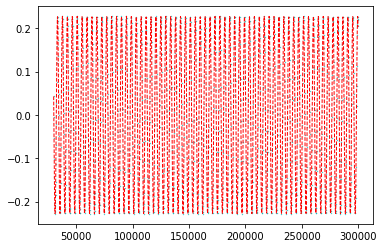

In [70]:
# Plot the noisy exponential data
plt.scatter(x_val, y_val, s=0.1, color='#00b3b3', label='Data')
plt.plot(x_val, fit_func_VD(x_val, *pars_VD), linestyle='--', linewidth=1, color='red')
#plt.ylim([0.0, 6000000000])
#plt.xlim([100000,150000])
plt.show()

In [71]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov_VD))
# Calculate the residuals
res = (y_val - fit_func_VD(x_val, *pars_VD))/y_err

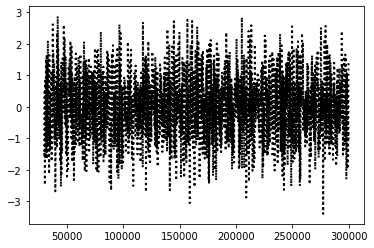

In [72]:
# Plot the noisy exponential data
plt.plot(x_val, res, linestyle='dotted', linewidth=2, color='black')
#plt.xlim([100000,150000])

In [73]:
pars_new

array([ 2.28201303e-01, -3.37834915e+01,  3.99688581e+00, -1.14413423e-03,
        2.03107558e+05,  2.33118149e-03,  2.57248781e+00,  3.59724194e-04,
       -8.35152377e-01,  1.12941915e-04,  1.56258962e+00, -7.26149660e-04,
        5.63249347e+04,  1.39005439e-02,  2.69431120e+00,  2.99363445e-03,
        2.10053632e+04,  1.40492785e-02,  1.97217746e+00,  2.92792620e-05,
        3.52342240e+00,  1.00000000e-04,  2.50000000e+00])

In [74]:
fou=abs(np.fft.fft(res))

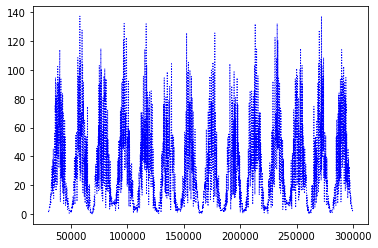

In [75]:
plt.plot(x_val, fou, linestyle='dotted', linewidth=1, color='blue')

In [76]:
chi2=np.dot((np.transpose(y_val-fit_func_VD(x_val, *pars_VD))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func_VD(x_val, *pars_VD)))))

In [77]:
chi2

1715.9446856118664

In [78]:
ndf=fit_range-len(pars_VD)

In [79]:
red_chi2=chi2/ndf

In [80]:
red_chi2

0.96564135374894

In [81]:
pars2

array([ 2.28201349e-01, -3.37846099e+01,  3.99688560e+00, -1.14305039e-03,
        2.03626485e+05,  2.33117914e-03,  2.57219573e+00,  3.58906396e-04,
       -8.28740735e-01,  1.11726273e-04,  1.53809801e+00, -7.24701884e-04,
        5.64131990e+04,  1.39005549e-02,  2.69512971e+00,  2.98327014e-03,
        2.10366522e+04,  1.40493085e-02,  1.97363689e+00,  2.92792620e-05,
        3.52342240e+00])

In [82]:
freq

array([-3.34546688e+001, -3.38432123e+001, -3.39095196e+001,
       -3.38691914e+001, -3.37814266e+001, -3.37846099e+001,
       -3.37834915e+001, -3.37834915e+001,  7.96968835e-316,
        7.96968598e-316])

In [83]:
dfreq

array([1.25721501e+000, 7.81830348e-001, 7.81399351e-001, 7.45626152e-001,
       6.30728506e-001, 6.30545711e-001,             inf,             inf,
       1.69759663e-313, 6.94603871e-310])

In [84]:
pars_VD

array([ 2.28201303e-01, -3.37834915e+01,  3.99688581e+00, -1.14413423e-03,
        2.03107558e+05,  2.33118149e-03,  2.57248781e+00,  3.59724194e-04,
       -8.35152377e-01,  1.12941915e-04,  1.56258962e+00, -7.26149660e-04,
        5.63249347e+04,  1.39005439e-02,  2.69431120e+00,  2.99363445e-03,
        2.10053632e+04,  1.40492785e-02,  1.97217746e+00,  2.92792620e-05,
        3.52342240e+00,  1.00000000e-04,  2.50000000e+00,  1.00000000e-06])

In [85]:
stdevs_VD

array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])